
#<b>1) connect to colab and import</b>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import cv2
import imutils
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage
from scipy.optimize import minimize
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler as ms
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

try:
  os.mkdir('drive/MyDrive/eschergrid')
except: 
  pass
finally:  
  try: 
    os.chdir('drive/MyDrive/eschergrid')
  except: 
    print('wrong directory error')

wrong directory error


In [25]:
# unzip for the first time
# or else don't unzip

!wget -nc "docs.google.com/uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ"
!wget -nc "docs.google.com/uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_"

!unzip -n 'uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_'
!unzip -n 'uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ'

File ‘uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ’ already there; not retrieving.

File ‘uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_’ already there; not retrieving.

Archive:  uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_
Archive:  uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ


In [26]:
# This is PYVIPS, a "faster"
# alternative to what we will actually do

# %capture
# !apt-get update
# !apt-get upgrade
# !apt-get install libvips
# !pip install pyvips
# !pip install cffi
# !pip show pyvips

# import pyvips

#<b>2) Define functions</b>

In [250]:
def plot_images(images, labels=False):
  L = len(images)
  if L>6:
    print('too many images (max 6)')
    return
  f, ax = plt.subplots(1,L, figsize=(L*5,L))
  for i in range(L):
    if len(images[i].shape)>2:
      ax[i].imshow(images[i])
    else:
      ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
    if labels:
      ax[i].set_title(labels[i])
  plt.show()

def rotate(img, deg: float):
  """
  rotates "deg" degrees
  clockwise
  """
  return imutils.rotate(img, -1*deg)


def scale(img, f: float):
  """
  scales by a factor "f"
  """
  # Store the original shape
  s = img.shape
  width = int(img.shape[1] * f)
  height = int(img.shape[0] * f)
  dim = (width, height)

  if f>1:
    # Define the pixel indexes in order to 
    # return an image with equal amount of pixels
    ind = [
           slice(
               int((s[0]*f)//2-s[0]//2),
               int((s[0]*f)//2+s[0]//2),
           ),
           slice(
               int((s[1]*f)//2-s[1]//2),
               int((s[1]*f)//2+s[1]//2),
           ),
    ]
    if len(s)>2:
      return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)[ind[0],ind[1],:]
    else:
      return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)[ind[0],ind[1]]
  canvas = np.zeros(s)
  new = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  a,b,c,d = s[0]//2-height//2, s[0]//2+height//2, s[1]//2-width//2, s[1]//2+width//2
  if len(s)>2:
    canvas[a:b,c:d,:] = new[:b-a, :d-c,:]
  else:
    canvas[a:b,c:d] = new[:b-a, :d-c] 
  return canvas

def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

history = {2:[],3:[],4:[],5:[]}
# base, target = [None],[None]

def optimize_image(deg, f, n, base_img,target_img):
  # Compute the cosine distance or the 'new' custom loss
  out = -1*np.sum(np.abs(target_img.flatten())*np.abs(rotate(scale(base_img,f),deg).flatten()))
  # out = distance.cosine(target_img.reshape(-1,),
  #                       rotate(scale(base_img,f),deg).reshape(-1,),
  #                       )
  history[n].append((deg, f, out))
  return out


def simone_method(base_img, target_img, n, LAPS=4, maxiter=50, verbose=True):
  """
  IMAGE must be 2,3,4 or 5
  """
  # global base
  # global target
  # base[0] = base_img
  # target[0] = target_img

  # Initialize the angle and the scaling factor
  # 1 degree (almost 0, the identity) and a scaling factor of "1" (identity)
  degree, scaling = 1,1

  # Define the optimizer

  # Four  iterations
  for _ in range(LAPS):
    # even iterations are for the scaling factor
    if _%2==0:
      opt = ["trust-constr","Nelder-Mead","Powell"][0]
      try:
        minimizer = lambda x,y: minimize(x,y,
                                      method=opt,
                                      options={'maxiter':maxiter},
                                      constraints=({'type': 'ineq', 'fun': lambda x: x-0.1},
                                                   {'type': 'ineq', 'fun': lambda x: 1.1-x},)
                                      )
      except:
        minimizer = lambda x,y: minimize(x,y,
                                      method=opt,
                                      options={'maxiter':maxiter}
                                      )
      res = minimizer(
                lambda x: optimize_image(degree,x,n,base_img,target_img),
                scaling,
                )      
      # update the scaling factor
      try:
        scaling = res.x[0].flatten()[0]
      except:
        scaling = res.x

    # odd iterations are for the degrees
    else:
      minimizer = lambda x,y: minimize(x,y,
                                  method=["BFGS","Nelder-Mead","Powell"][-1],
                                  options={'maxiter':maxiter}
                                  )
      res = minimizer(
            lambda Y: optimize_image(Y, scaling, n,base_img,target_img),
                degree, 
                )
      
      # update the rotation angle
      try:
        degree = res.x[0].flatten()[0]
      except:
        degree = res.x
    # print the last params
    if verbose:
      print(f'parameters after lap {_+1} are: ',res.x)

  return degree, scaling 

def splitter(imgs, params):
  full, target = imgs
  deg, scalef = params
  return np.abs(rotate(scale(full,scalef),deg) - target)  

def show(n, VERSIE=1):

  f, ax = plt.subplots(figsize=(20,4))

  deg, sc, cost = zip(*history[n])
  xvec = range(len(deg))

  sdeg = ms().fit([[x] for x in deg])
  ax.plot(sdeg.transform([[x] for x in deg]), c='orange')
  ax.scatter(xvec, sdeg.transform([[x] for x in deg]), label='degrees', c='orange')
  #ax.hlines(sdeg.transform([[30]])[0],0,len(sc), color='orange', ls=":", label='optimal degrees')

  ax.plot(sc, c='b')
  ax.scatter(xvec, sc, label='scaling', c='b')
  #ax.hlines(1.9,0,len(deg),color='b', ls=":", label='optimal scaling')

  ax.plot(ms().fit_transform([[x] for x in cost]), c='k')
  ax.scatter(range(len(deg)),ms().fit_transform([[x] for x in cost]), label='cost', c='k' )

  ax.set_ylim(-0.3,3.2)
  ax.legend()
  plt.show()

  f,ax = plt.subplots(1,3, figsize=(14,10))
  ax[1].imshow(scale(rotate(images[n-1],results[n][VERSIE][0]),results[n][VERSIE][1]).astype('uint8'))
  ax[2].imshow(images[n].astype('uint8'))
  ax[0].imshow(images[n-1].astype('uint8'))
  ax[1].set_title(f'optimized\nDEG:{round(results[n][VERSIE][0],2)} , SCALE:{round(results[n][VERSIE][1],2)}')
  ax[2].set_title('TARGET') 
  ax[0].set_title('BASE')
  plt.show()

#<b> 3) Load data and visualize </b>

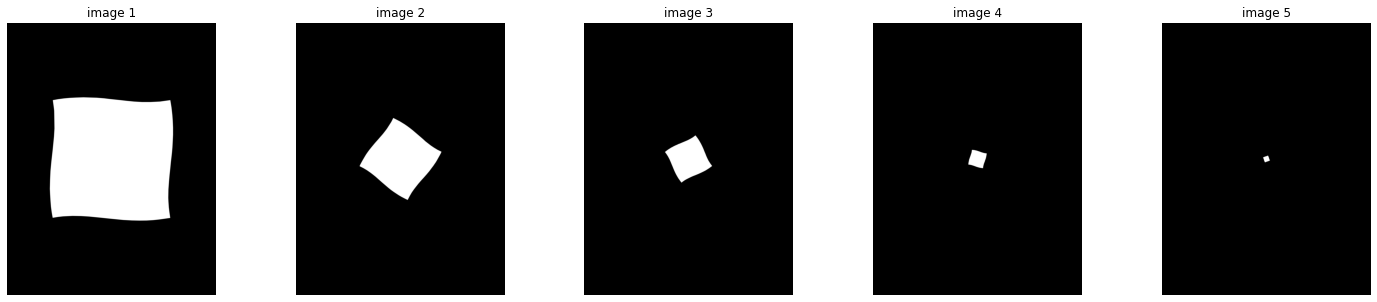

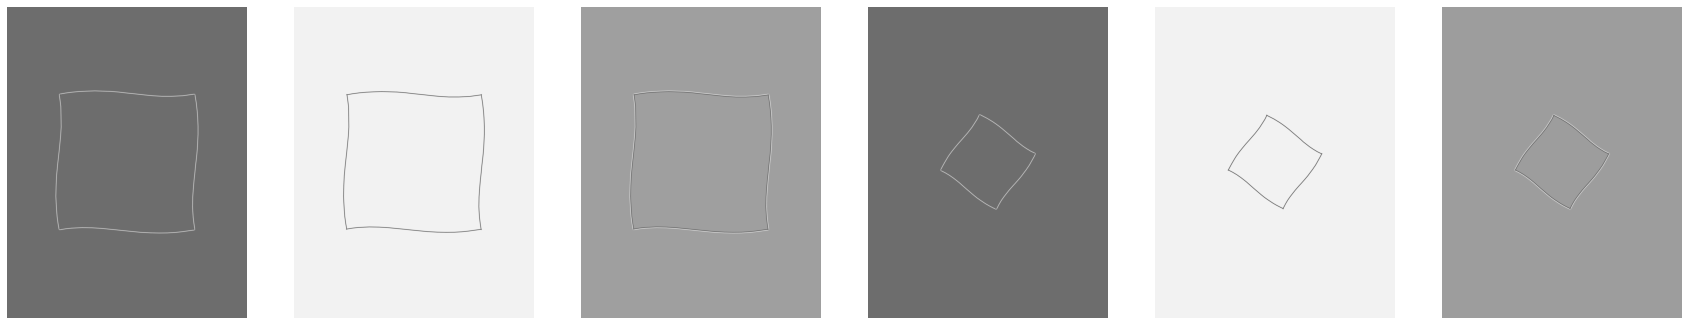

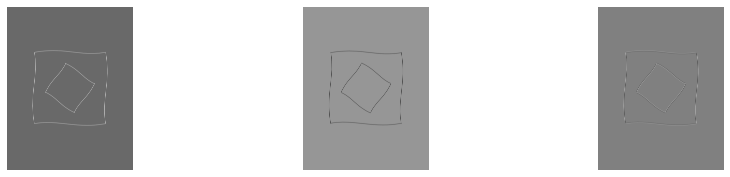

In [251]:
# Names of the files
types = ['B', 'TRANSP'][0] #RGB or Transparent
files = [
 f'escher_grid CUADRADO 1 {types}.png',
 f'escher_grid CUADRADO 2 {types}.png',
 f'escher_grid CUADRADO 3 {types}.png',
 f'escher_grid CUADRADO 4 {types}.png',
 f'escher_grid CUADRADO 5 {types}.png',
 ]

# Build a dictionary
images = {i+1:x for i,x in enumerate(files)}

images = {k:cv2.imread(v, 
                       #cv2.IMREAD_UNCHANGED,
                       cv2.IMREAD_COLOR,
                       ) for k,v in images.items()}

# Show them
plot_images([images[i+1] for i in range(len(images))],
            labels=[f'image {i+1}' for i in range(len(images))])
img = cv2.imread(files[0], 0) # 0 imports a grayscale

# Make the base and target images please
GENERATING_IMAGES = detect_ridges((images[1]-images[2])[:,:,0], sigma=3.0)
GENERATING_IMAGES = list(GENERATING_IMAGES) + [GENERATING_IMAGES[0]+GENERATING_IMAGES[1]]
GENERATING_IMAGES = [k.astype(float) for k in GENERATING_IMAGES]

TARGET_IMAGE = detect_ridges((images[2])[:,:,0], sigma=3.0)
TARGET_IMAGES = list(TARGET_IMAGE) + [TARGET_IMAGE[0]+TARGET_IMAGE[1]]
TARGET_IMAGES = [k.astype(float) for k in TARGET_IMAGES]

BASE_IMAGE = detect_ridges((images[1])[:,:,0], sigma=3.0)
BASE_IMAGES = list(BASE_IMAGE) + [BASE_IMAGE[0] + BASE_IMAGE[1]]
BASE_IMAGES = [k.astype(float) for k in BASE_IMAGES]


plot_images(BASE_IMAGES+TARGET_IMAGES)
plot_images(GENERATING_IMAGES)

#<b>4) Perform the ground-zero optimization task</b>

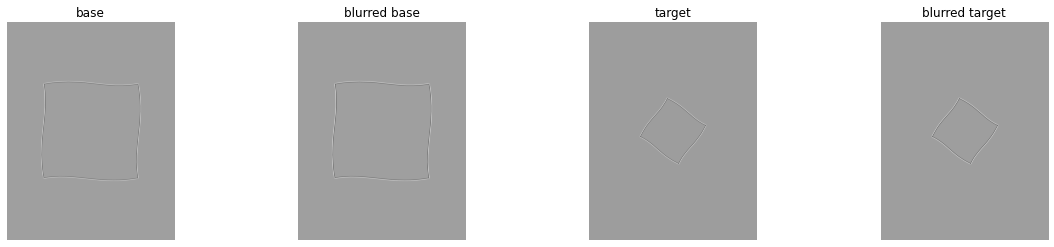

In [252]:
sg=10 #blurred deviation
VERSIE = 2
plot_images([BASE_IMAGES[VERSIE],
             cv2.GaussianBlur(BASE_IMAGES[VERSIE],(5,5),sg, sigmaY=sg), 
             TARGET_IMAGES[VERSIE], 
             cv2.GaussianBlur(TARGET_IMAGES[VERSIE],(5,5),sg, sigmaY=sg)],
            ['base','blurred base', 'target', 'blurred target'])

if True:
  BASE_IMAGES = [cv2.GaussianBlur(x,(5,5),sg, sigmaY=sg) for x in BASE_IMAGES]
  TARGET_IMAGES = [cv2.GaussianBlur(x,(5,5),sg, sigmaY=sg) for x in TARGET_IMAGES]
  GENERATING_IMAGES = [cv2.GaussianBlur(x,(5,5),sg, sigmaY=sg) for x in GENERATING_IMAGES]

<b>Let's fit it</b>

In [253]:
# An arbitrary container
results = {2:{0:None, 1:None, 2:None}}

# Perform the optimization process please   
VERSIE = 2
#                                                                                                    laps maxiter
results[2][VERSIE] = [x.flatten()[0] for x in simone_method(BASE_IMAGES[VERSIE],TARGET_IMAGES[VERSIE], 2, 100, 50, verbose=False)]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


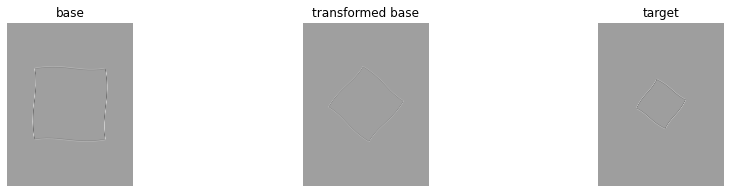

In [254]:
plot_images([BASE_IMAGES[VERSIE],
             scale(rotate(BASE_IMAGES[VERSIE], results[2][VERSIE][0]), results[2][VERSIE][1]),
             TARGET_IMAGES[VERSIE]],
            ['base','transformed base','target'],
            )

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

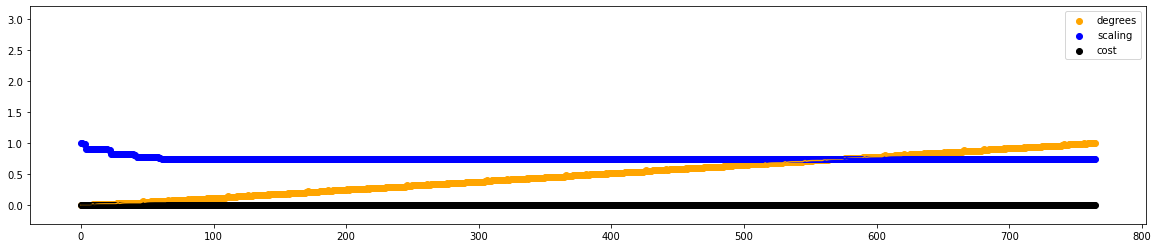

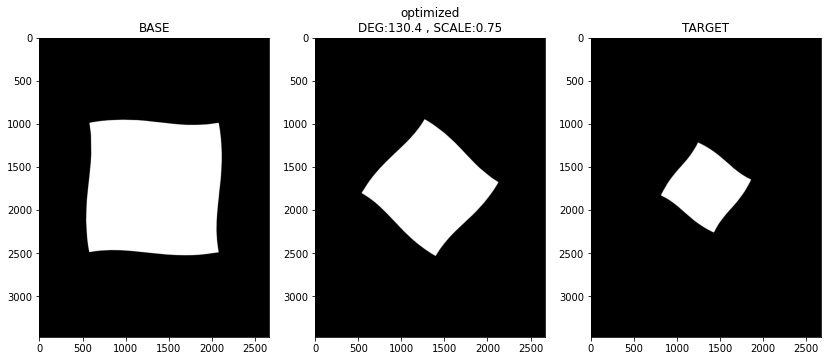

In [255]:
show(2, 2)

#<b>5) Self generating mechanism</b>

In [59]:
IMAGE_HISTORY = {}
results = {}
ALIGN_INDEX = 0
for n in [2,3,4,5]:
  results[n] = {x_:None for x_ in [0,1,2]}
  for i in [1]:#range(3):
    results[n][i] = [x.flatten()[0] for x in simone_method(BASE_IMAGES[i], TARGET_IMAGES[i], n)]
  BASE_IMAGES, TARGET_IMAGES = TARGET_IMAGES,[splitter(img, results[n][i]) for img in zip(*[GENERATING_IMAGES, TARGET_IMAGES])]
  IMAGE_HISTORY[n] = TARGET_IMAGES[1].copy()

parameters after lap 1 are:  [1.]
parameters after lap 2 are:  [1.]
parameters after lap 3 are:  [1.]
parameters after lap 4 are:  [1.]
parameters after lap 1 are:  [1.15]
parameters after lap 2 are:  [1.]
parameters after lap 3 are:  [1.15]
parameters after lap 4 are:  [1.]
parameters after lap 1 are:  [0.99335938]
parameters after lap 2 are:  [0.721875]
parameters after lap 3 are:  [0.99559055]
parameters after lap 4 are:  [0.44320587]
parameters after lap 1 are:  [0.99335938]
parameters after lap 2 are:  [0.64179687]
parameters after lap 3 are:  [0.99646362]
parameters after lap 4 are:  [-0.21322197]


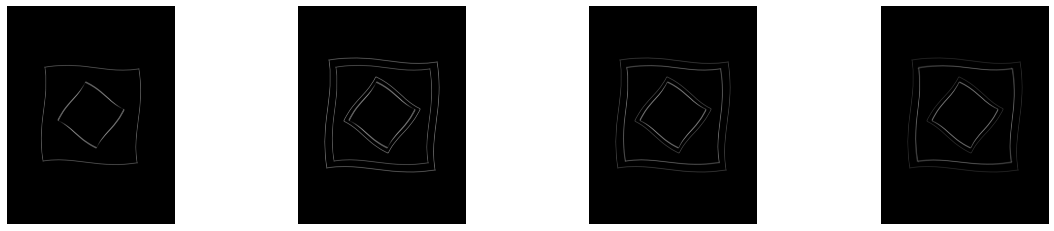

In [60]:
plot_images([IMAGE_HISTORY[n] for n in [2,3,4,5]])

#<b>4) View the optimization process</b>

<b>PLOT THE PARAMETERS AND COST DURING THE OPTIMIZATION PROCESS</b>

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

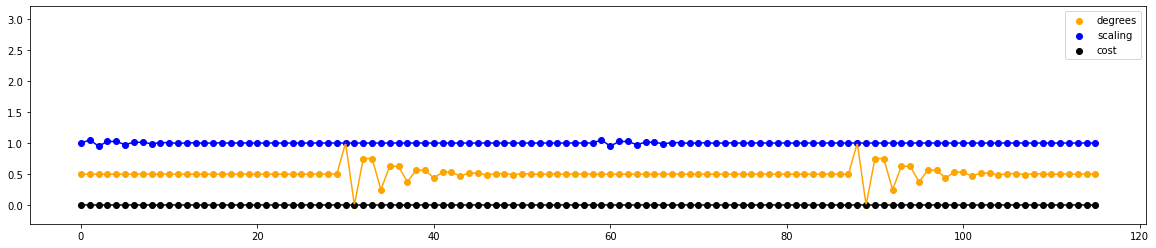

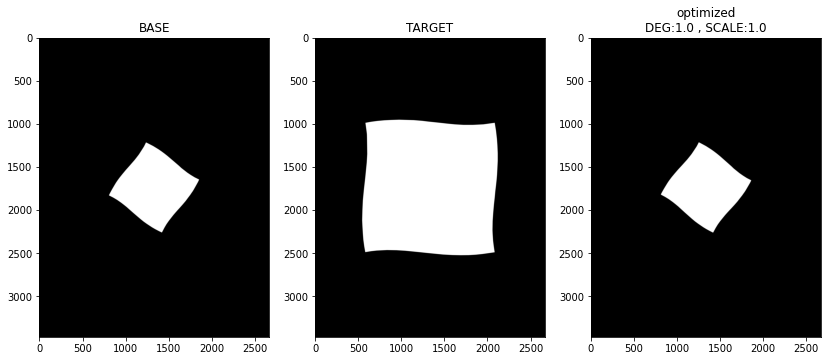

In [48]:
show(2)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

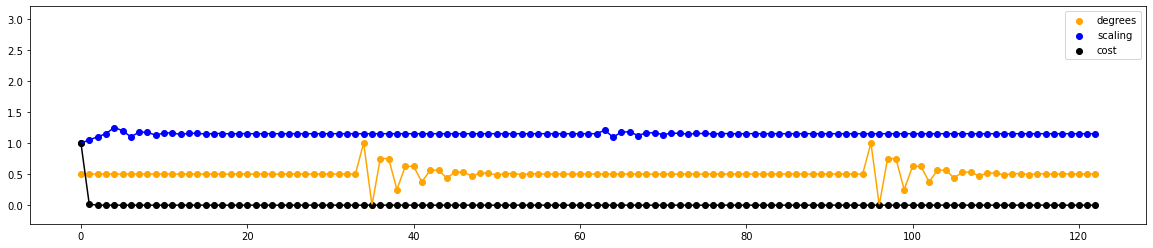

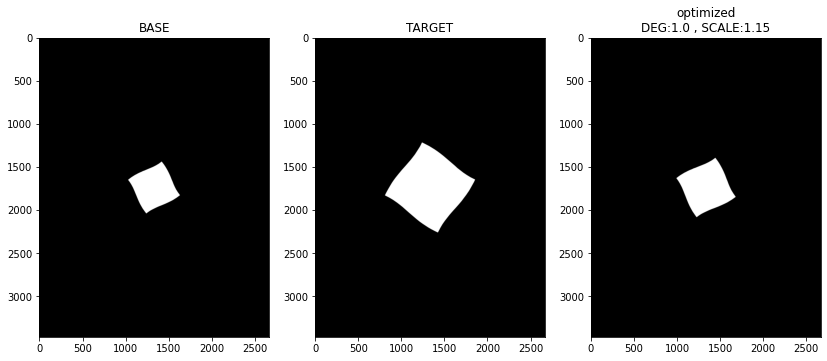

In [49]:
show(3)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

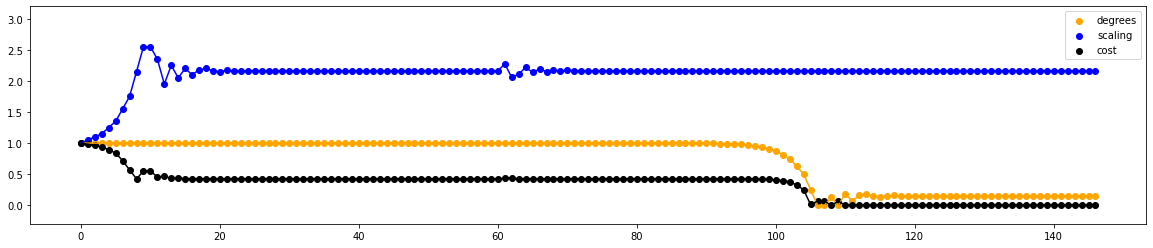

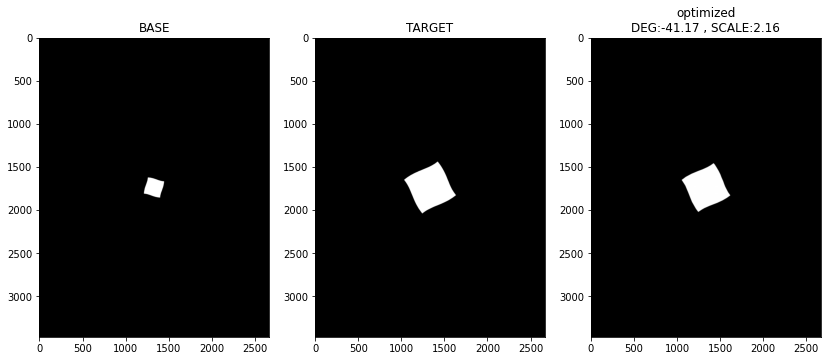

In [ ]:
show(4)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

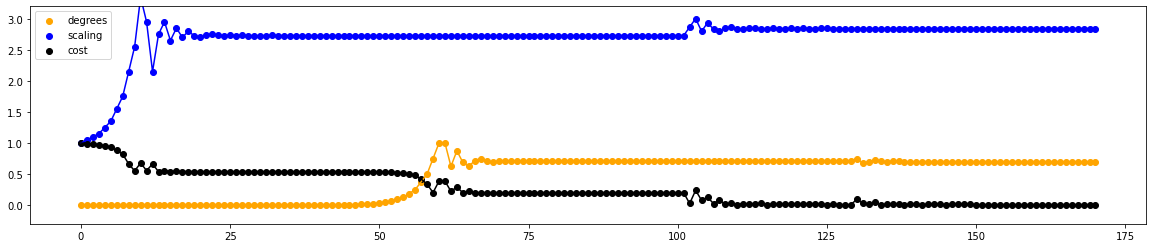

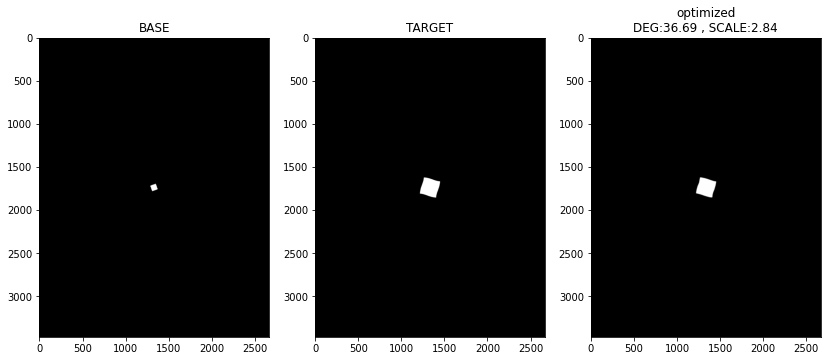

In [ ]:
show(5)

<b>THE PARAMETERS FOR EACH</b>

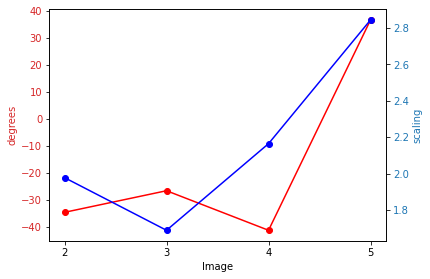

In [ ]:
degrees, scaling = [],[]
for i in [2,3,4,5]:
  local = results[i]
  degrees.append(local[0])
  scaling.append(local[1])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('degrees', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([2,3,4,5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('scaling', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax1.scatter([2,3,4,5], degrees, label="degrees", c='r')
ax1.plot([2,3,4,5],degrees, c='r')
ax2.scatter([2,3,4,5], scaling, label="scaling", c='b')
ax2.plot([2,3,4,5],scaling, c='b')
#ax1.legend()
#ax2.legend()
plt.show()

#<b>Appendix A) enlarge the last two images in order to reduce the error in the optimization parameters</b> (used in the old version)

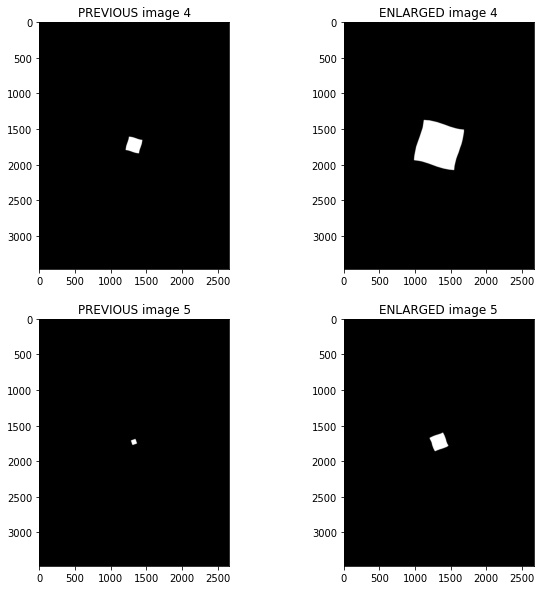

In [ ]:
factor = 3
f, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(images[4].astype('uint8'))
ax[0,0].set_title('PREVIOUS image 4')
ax[1,0].imshow(images[5].astype('uint8'))
ax[1,0].set_title('PREVIOUS image 5')
for im in [4,5]:
  images[im] = scale(images[im],factor)
ax[0,1].imshow(images[4].astype('uint8'))
ax[0,1].set_title('ENLARGED image 4')
ax[1,1].imshow(images[5].astype('uint8'))
ax[1,1].set_title('ENLARGED image 5')

plt.show()

In [ ]:
history[5] = []
results[5] = simone_method(5)

parameters after lap 1 are:  [2.7359375]
parameters after lap 2 are:  [37.29453125]
parameters after lap 3 are:  [2.85563477]
parameters after lap 4 are:  [36.60800594]


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

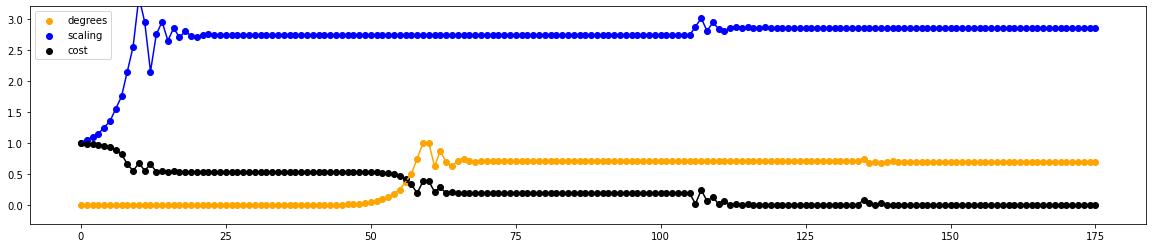

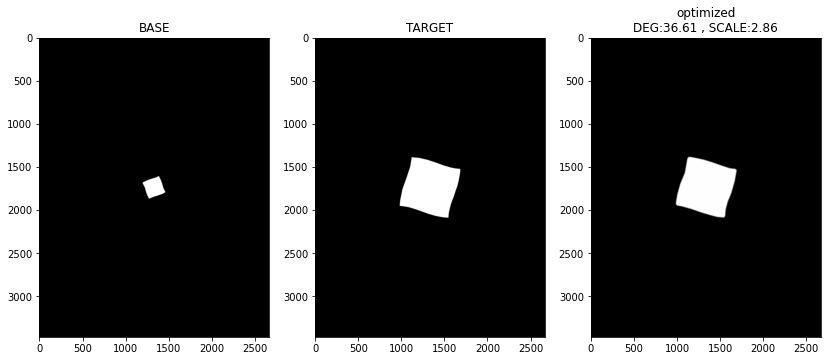

In [ ]:
show(5)

<b>At last show that the diference in rotation and scaling factor is not due to a lack-of-resolution error.</b>

<i>COMMENT: Rotation 'may' be degenerated by 90°, so the sign in ±35° could be irrelevant. What about the scaling ~30% difference tho? </i>

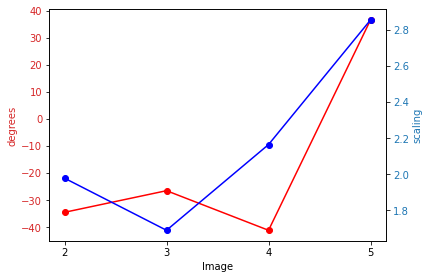

In [ ]:
degrees, scaling = [],[]
for i in [2,3,4,5]:
  local = results[i]
  degrees.append(local[0])
  scaling.append(local[1])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('degrees', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([2,3,4,5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('scaling', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax1.scatter([2,3,4,5], degrees, label="degrees", c='r')
ax1.plot([2,3,4,5],degrees, c='r')
ax2.scatter([2,3,4,5], scaling, label="scaling", c='b')
ax2.plot([2,3,4,5],scaling, c='b')
#ax1.legend()
#ax2.legend()
plt.show()